In [8]:
# Setup
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.text.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
Mounted at /content/gdrive


In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Load the datasets
train_df = pd.read_csv('/content/drive/MyDrive/NLP/twitter_training.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/NLP/twitter_validation.csv')

In [11]:
# Ensure columns are named appropriately
train_df.columns = ['id', 'information', 'type', 'text']
valid_df.columns = ['id', 'information', 'type', 'text']

In [12]:
# Combine the training and validation sets for language model fine-tuning
df = pd.concat([train_df, valid_df], ignore_index=True)

In [13]:
# Check the type value counts
print(train_df['type'].value_counts())

type
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


In [14]:
# Create a DataBlock for language model
language_model_block = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)  # Use 10% of the data for validation
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [15]:
# Create DataLoaders for the language model
language_model_loaders = language_model_block.dataloaders(df, bs=128, seq_len=80)

In [16]:
# Show a batch to confirm
language_model_loaders.show_batch(max_n=3)

,text,text_
0,xxbos @davidmickner @joececot have you today thinking about the respawning power of 2v2 gunfight ? i think it d be awesome to also like this mini deathmatch option . xxmaj food for thought . xxbos xxbos xxmaj it is not the first time that the xxup eu xxmaj commission has taken such a step . xxbos xxmaj i ’m live on xxmaj twitch - xxmaj watch me at twitch.tv / osg_shotz we back xxbos xxmaj outrageous and unnecessary . xxmaj,@davidmickner @joececot have you today thinking about the respawning power of 2v2 gunfight ? i think it d be awesome to also like this mini deathmatch option . xxmaj food for thought . xxbos xxbos xxmaj it is not the first time that the xxup eu xxmaj commission has taken such a step . xxbos xxmaj i ’m live on xxmaj twitch - xxmaj watch me at twitch.tv / osg_shotz we back xxbos xxmaj outrageous and unnecessary . xxmaj white
1,"ghostrecon i was wondering if anyone is listening and if so , are you out of date or working on xxmaj breakpoint . xxmaj this is a serious question due to recent events that a xxmaj youtuber has made us aware that you are in financial trouble . xxmaj is that the reason why xxmaj update 1.1.0 is no longer available ? xxbos @verizon 's store policies are killing popular brick and mortar stores . xxbos xxmaj zero xxmaj days","i was wondering if anyone is listening and if so , are you out of date or working on xxmaj breakpoint . xxmaj this is a serious question due to recent events that a xxmaj youtuber has made us aware that you are in financial trouble . xxmaj is that the reason why xxmaj update 1.1.0 is no longer available ? xxbos @verizon 's store policies are killing popular brick and mortar stores . xxbos xxmaj zero xxmaj days attack"
2,"rewards amazon.in / game / share / g4 g … xxbos i very edited up this a while ago , i do really have to get back into editing , because it ’ don s pretty fun when the motivations hit ! .. xxbos xxmaj black xxmaj ops xxmaj cold xxmaj war xxmaj beta ! ! i still suck at xxup pc shooters ! .. twitch.tv / popgoesthecorn xxbos "" great experience from the very start . "" says xxmaj","amazon.in / game / share / g4 g … xxbos i very edited up this a while ago , i do really have to get back into editing , because it ’ don s pretty fun when the motivations hit ! .. xxbos xxmaj black xxmaj ops xxmaj cold xxmaj war xxmaj beta ! ! i still suck at xxup pc shooters ! .. twitch.tv / popgoesthecorn xxbos "" great experience from the very start . "" says xxmaj allison"


In [17]:
# Let's build a learner for the language model
learner = language_model_learner(
    language_model_loaders,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=[accuracy, Perplexity()]
).to_fp16()

LR suggestion = 5.25e-03


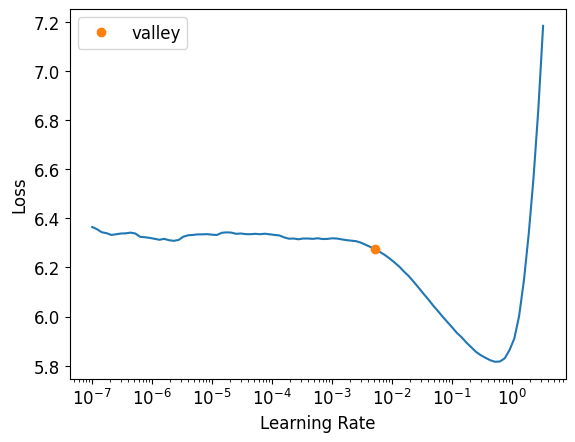

In [21]:
# What's a good learning rate for this model-problem?
lr_suggestion = learner.lr_find( )
print( f"LR suggestion = {lr_suggestion[ 0 ]:.2e}" )

In [22]:
# Let's do a single fine tune epoch with the suggested LR to see where we are --
# remember a single fine tuning epoch involves one epoch
learner.fit( 1, lr=5.25e-03 )

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.543710,4.270670,0.284236,71.569603,01:30


In [27]:
# Fine tune the language model
learner.fit(1, lr=5.25e-03)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.693609,3.681654,0.347032,39.712013,01:30


In [28]:
# Fine tune the language model
learner.fit(1, lr=5.25e-03)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.522844,3.563359,0.361426,35.281494,01:34


In [30]:
for i in range(2):  # Loop for fine-tuning iterations
    print(f"\n\nfine tuning iteration #{i+1}")  # Print the current fine-tuning iteration number
    learner.fine_tune(1, base_lr = 5.25e-03 )  # Fine-tune the model for 1 epoch with the preferred learning rate



fine tuning iteration #1


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.857749,3.128309,0.425450,22.835339,01:30


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.770754,3.061213,0.439462,21.353437,01:33




fine tuning iteration #2


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.729150,3.047523,0.440672,21.063097,01:30


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.664086,2.988194,0.452367,19.849806,01:32


In [32]:
# Save the encoder
language_model_path = "/content/models/finetuned.pth"
learner.save_encoder(language_model_path)

In [33]:
# Create DataBlock and DataLoaders for classification
vocabulary = language_model_loaders.vocab
classification_block = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=vocabulary), CategoryBlock),
    get_y=ColReader('type'),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.2)
)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [35]:
# Combine the training and validation sets
df = pd.concat([train_df, valid_df], ignore_index=True)

In [36]:
# Create DataLoaders for classification
classification_loaders = classification_block.dataloaders(df, bs=64)

In [37]:
# Show a batch to confirm
classification_loaders.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy",Irrelevant
1,"xxbos xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy , xxmaj italy",Irrelevant
2,"xxbos @gop and xxunk xxup and xxup this xxup of xxup book xxup exposes "" xxup the xxup pot xxup calling xxup the xxup kettle xxup black "" xxup to xxup confront xxup if xxup the xxup evildoers xxup and xxup partisan xxup politics xxup of xxup that xxup is a xxup destroying xxup america … i pray that by you read these few pages with an open mind - xxup jesus xxup is xxup who xxup only xxup and xxup one xxup without xxup sin — 3 xxmaj available on xxmaj amazon amazon . com / dp / 1661386431 ? … https : / / t.co / lg9f27jefu ]",Neutral


In [38]:
# Create the classification learner
learner = text_classifier_learner(
    classification_loaders,
    AWD_LSTM,
    drop_mult=0.3,
    metrics=accuracy
).to_fp16()

In [39]:
# Load the fine-tuned encoder
learner.load_encoder(language_model_path)

In [40]:
# Fine-tune the classifier
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.092810,1.011921,0.579083,01:37


epoch,train_loss,valid_loss,accuracy,time
0,0.950630,0.866390,0.649247,01:44


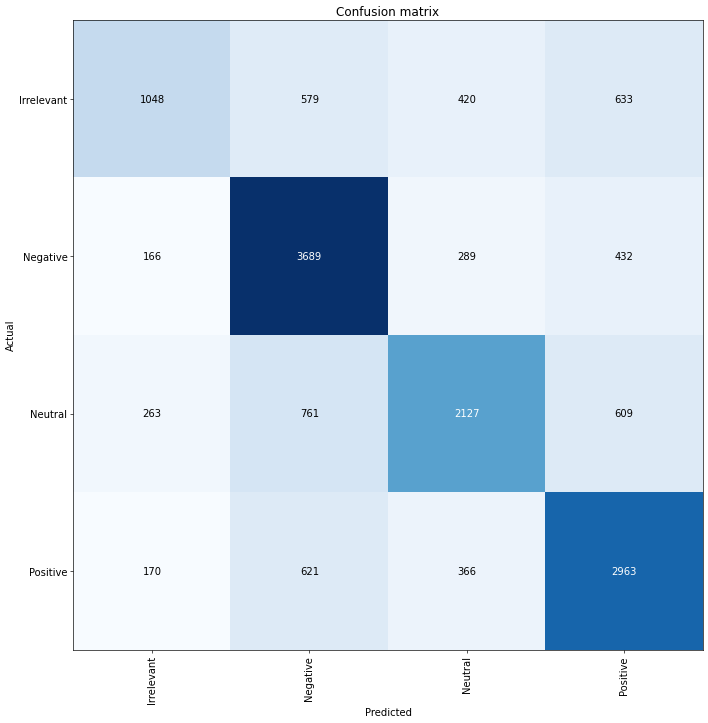

In [41]:
# Plot confusion matrix after single epoch
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix(figsize=(12, 12), dpi=60)

LR suggestion: 2.29e-04


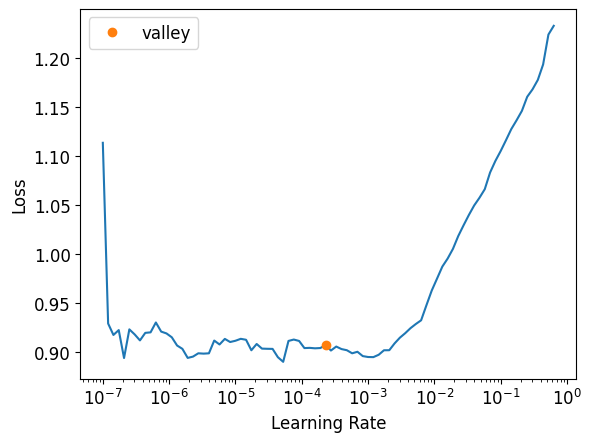

In [42]:
# Find a good learning rate
lr_suggestion = learner.lr_find()
print(f"LR suggestion: {lr_suggestion[0]:.2e}")

In [43]:
# Gradual unfreezing and further fine-tuning
for i in range(1):
    print(f"\n\nfine tuning iteration #{i+1}")
    learner.fine_tune(1, base_lr=2.29e-04)



fine tuning iteration #1


epoch,train_loss,valid_loss,accuracy,time
0,0.906768,0.840970,0.657505,01:44


epoch,train_loss,valid_loss,accuracy,time
0,0.862472,0.817124,0.671181,01:45


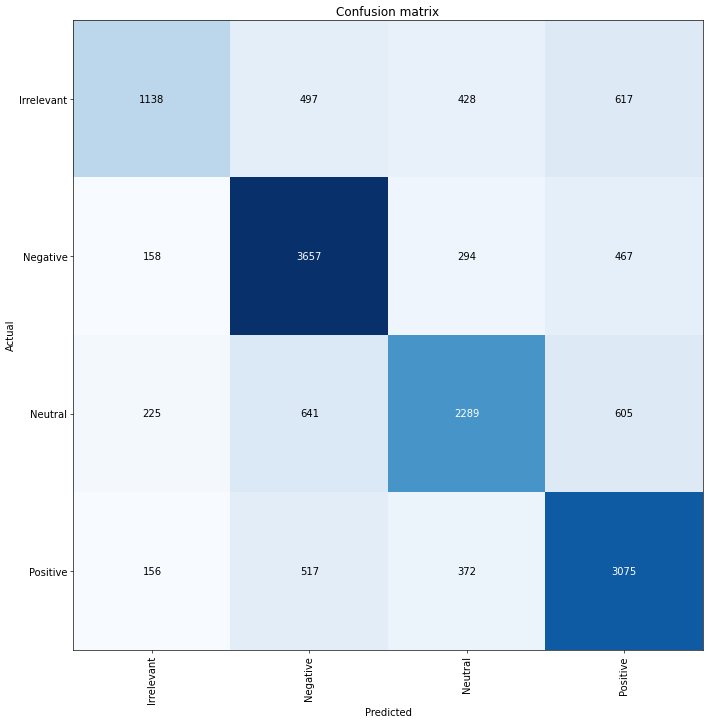

In [44]:
# Plot final confusion matrix
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [47]:
from sklearn.metrics import classification_report

# Get predictions and targets
pred_scores, targets = learner.get_preds()
preds = torch.argmax(pred_scores, dim=1)

# Generate classification report
target_names = ['Negative', 'Positive', 'Neutral', 'Irrelevant']
report = classification_report(targets, preds, target_names=target_names)
print(report)


              precision    recall  f1-score   support

    Negative       0.68      0.42      0.52      2680
    Positive       0.69      0.80      0.74      4576
     Neutral       0.68      0.61      0.64      3760
  Irrelevant       0.65      0.75      0.69      4120

    accuracy                           0.67     15136
   macro avg       0.67      0.64      0.65     15136
weighted avg       0.67      0.67      0.66     15136



In [52]:
# Save the classifier
classifier_dir = "/content/drive/MyDrive/NLP"
if not os.path.exists(classifier_dir):
    os.makedirs(classifier_dir)

classifier_path = os.path.join(classifier_dir, "twitter_sentiment_classifier.pkl")
learner.export(classifier_path)

In [53]:
# Load the model and make a prediction
learner = load_learner(classifier_path)
content = "I love the new design of your website!"
prediction, prediction_possibility, prediction_possibilities = learner.predict(content)
print(f"prediction = {prediction}\n\n")

prediction = Positive


